In [1]:
import os.path
import cv2
import stasm
import numpy as np
import matplotlib.pyplot as plt

## Config

In [2]:
IMAGES_PATH = '../../images/'
GEN_IMAGES_PATH = '../../generated_images/'

## Step 1 : Using PyStasm to generate landmarks in reference and target image

In [3]:
ref = cv2.imread(os.path.join(IMAGES_PATH, 'ref.png'))
ref_color = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

In [4]:
target = cv2.imread(os.path.join(IMAGES_PATH, 'target.png'))
target_color = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Target Image')

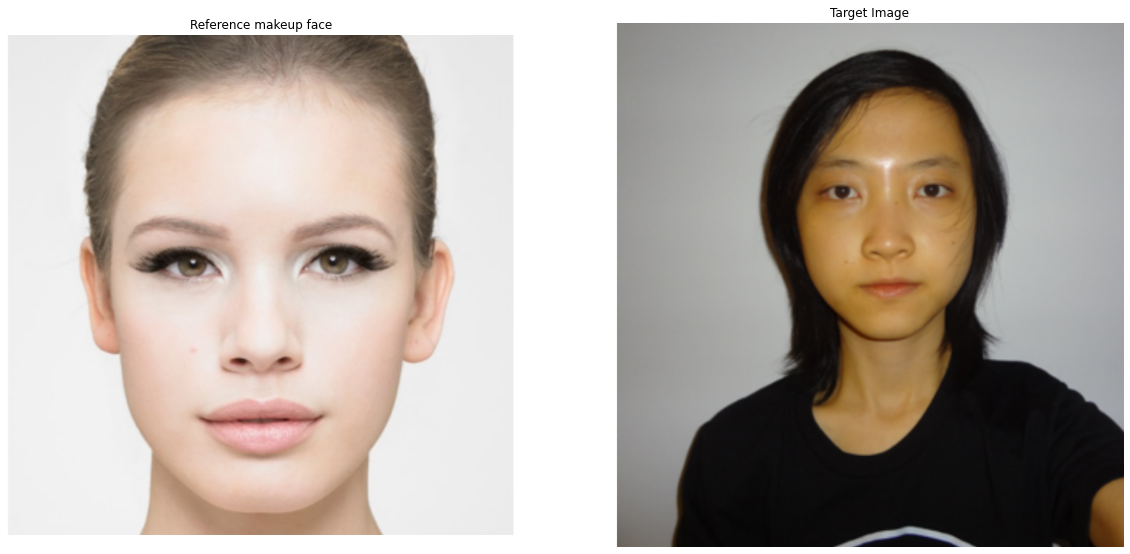

In [5]:
fig = plt.figure(figsize = (20, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(ref_color)
plt.axis('off')
plt.title("Reference makeup face")

fig.add_subplot(1, 2, 2)
plt.imshow(target_color)
plt.axis('off')
plt.title("Target Image")



In [6]:
ref_gray = cv2.cvtColor(ref_color, cv2.COLOR_RGB2GRAY)
target_gray = cv2.cvtColor(target_color, cv2.COLOR_RGB2GRAY)

In [7]:
ref_landmarks = stasm.search_single(ref_gray)
target_landmarks = stasm.search_single(target_gray)

ref_l = stasm.force_points_into_image(ref_landmarks, ref_gray)
target_l = stasm.force_points_into_image(target_landmarks, target_gray)

In [8]:
## Making landmark points white
ref_copy = ref_color.copy()
target_copy = target_color.copy()

black = (0,0,0)
for x, y in ref_l:
    ref_copy = cv2.circle(ref_copy, (round(x), round(y)), 2, black, 1)
    
white = (255,255,255)
for x, y in target_l:
    target_copy = cv2.circle(target_copy, (round(x), round(y)), 1, white, 1)

Text(0.5, 1.0, 'Target Landmarks')

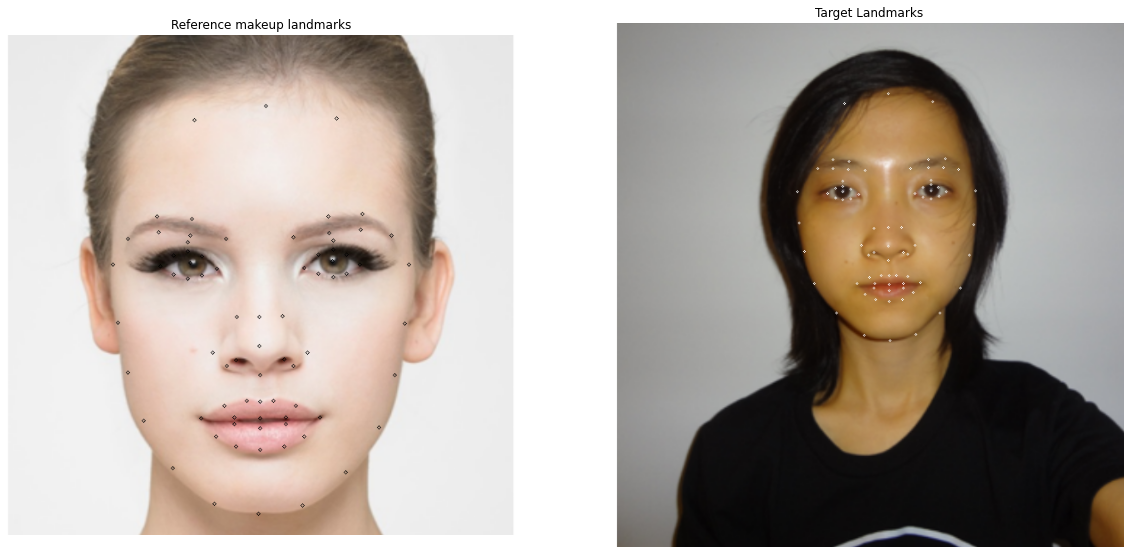

In [9]:
fig = plt.figure(figsize = (20, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(ref_copy)
plt.axis('off')
plt.title("Reference makeup landmarks")

fig.add_subplot(1, 2, 2)
plt.imshow(target_copy)
plt.axis('off')
plt.title("Target Landmarks")

### Saving images 

In [10]:
cv2.imwrite(os.path.join(GEN_IMAGES_PATH, 'ref_dotted.png'),cv2.cvtColor(ref_copy, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(GEN_IMAGES_PATH, 'target_dotted.png'),cv2.cvtColor(target_copy, cv2.COLOR_BGR2RGB))

True

## Step 2 : Thin plate splice warping

#### tpsMap

In [11]:
def tpsMap(wW, imgH, imgW, xp, yp, NPs):
    X, Y = np.meshgrid(np.arange(1, imgH + 1), np.arange(1, imgW + 1))
    X = X.T.flatten().reshape(1, -1)
    Y = Y.T.flatten().reshape(1, -1)
    _, NWs = X.shape
    
    rx = np.repeat(X, NPs, axis = 0)
    ry = np.repeat(Y, NPs, axis = 0)
    
    assert rx.shape == (NPs, NWs), "Shape of rx is not right"
    assert ry.shape == (NPs, NWs), "Shape of ry is not right"

    rxP = np.repeat(xp.reshape(-1, 1), NWs, axis = 1)
    ryP = np.repeat(yp.reshape(-1, 1), NWs, axis = 1)
    
    assert rxP.shape == (NPs, NWs), "Shape of rxP is not right"
    assert ryP.shape == (NPs, NWs), "Shape of ryP is not right"
    
    wR = np.sqrt((rx - rxP)**2 + (ry - ryP)**2)
    wK = radial_basis(wR)
    assert wK.shape == (NPs, NWs)
    wP = np.hstack((np.ones((NWs, 1)), X.T, Y.T)).T
    
    wL = np.vstack((wK, wP)).T
    
    Xw = wL @ wW[:, 0]
    Yw = wL @ wW[:, 1]
    return Xw, Yw

#### Inverse distance weighted interpolation function

In [12]:
def compWk(map_h, cx, cy, p):
    h, w = map_h.shape
    x, y = np.meshgrid(np.arange(1,h + 1), np.arange(1, w + 1))
    y = (y - cy)**2
    x = (x - cx)**2
    d2 = x + y
    ans = 1 / (np.power(d2.T, p / 2))
    return ans

def idw(in_h, map_h, wk):
    num = np.sum(in_h[map_h != 0].astype(dtype=np.double) * wk[map_h != 0])
    den = np.sum(wk[map_h != 0])
    return num / den

def idwMvInterp(imgw, map_holes, maxhw, p):
    '''
    Fill holes using Inverse Distance weighted interpolation
    '''
    outH, outW, color = imgw.shape
    out = imgw.copy()
    yi_arr, xi_arr = np.where(map_holes == 0)
    assert xi_arr.size == yi_arr.size, "Normie check"
    
    yi_size = yi_arr.size

    if yi_size != 0:
        for ix in range(yi_size):
            
            xi = xi_arr[ix]
            yi = yi_arr[ix]
            yixL = max(yi - maxhw, 1)
            yixU = min(yi + maxhw, outH)
            xixL = max(xi - maxhw, 1)
            xixU = min(xi + maxhw, outW)
            
            mapw = map_holes[yixL - 1:yixU,xixL - 1:xixU]
            if np.where(mapw.flatten() == 1)[0].size != 0:
                wk = compWk(mapw, xi - xixL + 1, yi - yixL + 1, p)
                
                for colIx in range(color):
                    out[yi, xi, colIx] = idw(imgw[yixL - 1:yixU,xixL - 1:xixU, colIx], mapw, wk)
                    
    return out

### interp2d

In [13]:
def interp2d(X, Y, img, Xwr, Ywr, outH, outW, interp):
    '''
    Args:
    X, Y = meshgrid of input image
    img = input image
    Xwr, Ywr = warped meshgrid
    outH, outW = dimensions of the output image
    interp = dictionary {'radius','power'}
    '''
    imgH, imgW, color = img.shape
    imgwr = np.zeros((outH, outW, color))
    try:
        maxhw = (interp['radius'] - 1) // 2
    except KeyError:
        print("interp has no radius key")
    Xwi = np.round(Xwr).astype(dtype=np.int)
    Ywi = np.round(Ywr).astype(dtype=np.int)
    
    Xwi = np.maximum(np.minimum(Xwi, outH),1)
    Ywi = np.maximum(np.minimum(Ywi, outW),1)
    fiw = np.ravel_multi_index(np.array([Xwi - 1, Ywi - 1]),(outH, outW), order='F')
    fip = np.ravel_multi_index(np.array([X - 1, Y - 1]),(imgH, imgW), order='F')
    fiw_m = np.loadtxt('../../matlab_files/fiw.txt').astype(dtype = np.int) - 1
    fip_m = np.loadtxt('../../matlab_files/fip.txt').astype(dtype=np.int) - 1
    
    ## fip is right, expected 6.7647e10, got 67646327931
    ## fiw is right, expected 4.4145e10, got 44144174403
    

    for colIx in range(color):
        o_r = np.zeros((outH, outW))
        img_r = img[:,:,colIx]
        p = o_r.flatten()
        p[fiw] = img_r.flatten(order='C')[fip]
        o_r = p.reshape(o_r.shape, order = 'F')
        imgwr[:,:,colIx] =  o_r
        
    map_holes = np.zeros((outH, outW))
    t = map_holes.flatten()
    t[fiw] = 1
    map_holes = t.reshape(map_holes.shape, order = 'F')
    
    po = 2
    try:
        po = interp['power']
    except KeyError:
        print("interp has no power along with invdist interpolation function, defaulting to power = 2")
    imgw = idwMvInterp(imgwr, map_holes, maxhw, po)
    
    return imgw, imgwr, map_holes

### tpsWarp - main function

In [14]:
def radial_basis(mat):
    q = mat.copy()
    q[mat == 0] = 1e-3
    return 2 * mat**2 * np.log(q)

In [15]:
def compute_Wl(xp, yp, NP):
    xp = xp.reshape(-1, 1)
    yp = yp.reshape(-1, 1)
    rXp = np.repeat(xp, NP, axis = 1)
    rYp = np.repeat(yp, NP, axis = 1)
    
    wR = np.sqrt((rXp - rXp.T)**2 + (rYp - rYp.T)**2)
    wK = radial_basis(wR)
    wP = np.hstack((np.ones((NP, 1)), xp, yp))
    
    wL_topRow = np.hstack((wK, wP))
    wL_bottomRow = np.hstack((wP.T, np.zeros((3, 3))))
    wL = np.vstack((wL_topRow, wL_bottomRow))
    return wL

In [16]:
def tpswarp(img, outDim, Zp, Zs, interp):
    NPs,_ = Zp.shape
    imgH, imgW, _ = img.shape
    Xp = Zp[:, 0].T
    Yp = Zp[:, 1].T

    Xs = Zs[:, 0].T
    Ys = Zs[:, 1].T
    outH, outW, _ = outDim
    
    wL = compute_Wl(Xp, Yp, NPs)
    
    ## wL is right == 26867 * 10^9
    assert wL.shape == (NPs + 3, NPs + 3), "Output wL is of wrong shape"
    wY_top = np.hstack((Xs.reshape(-1, 1), Ys.reshape(-1, 1)))
    wY_bottom = np.zeros((3, 2))
    wY = np.vstack((wY_top, wY_bottom))
    
    ## wY is right == 41174
    assert wY.shape == (NPs + 3, 2)
    wW = np.linalg.inv(wL) @ wY
    
    ## wW is right == 155.1481
    assert wW.shape == (NPs + 3, 2)
    Xw, Yw = tpsMap(wW, imgH, imgW, Xp, Yp, NPs)
    
    ## Xw is right, expected 1.1105 * 1e8, got 111046639.14
    ## Yw is right, expected 7.5128 * 1e7, got 75127850.684
    
    x, y = np.meshgrid(np.arange(1,imgH + 1), np.arange(1,imgW + 1))
    imgw, imgwr, map_h = interp2d(x.flatten(), y.flatten(), img, Xw, Yw,outH, outW, interp)
    return imgw, imgwr, map_h

In [17]:
interp = {
    'radius' : 5,
    'power' : 2
}

In [18]:
a, b, c = tpswarp(ref_color, target_color.shape, np.flip(ref_l, 1), np.flip(target_l, 1), interp)

/home/shaunak/miniconda2/envs/dip/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/shaunak/miniconda2/envs/dip/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [19]:
a_disp = np.uint8(a)
b_disp = np.uint8(b)

Text(0.5, 1.0, 'Holes in the image')

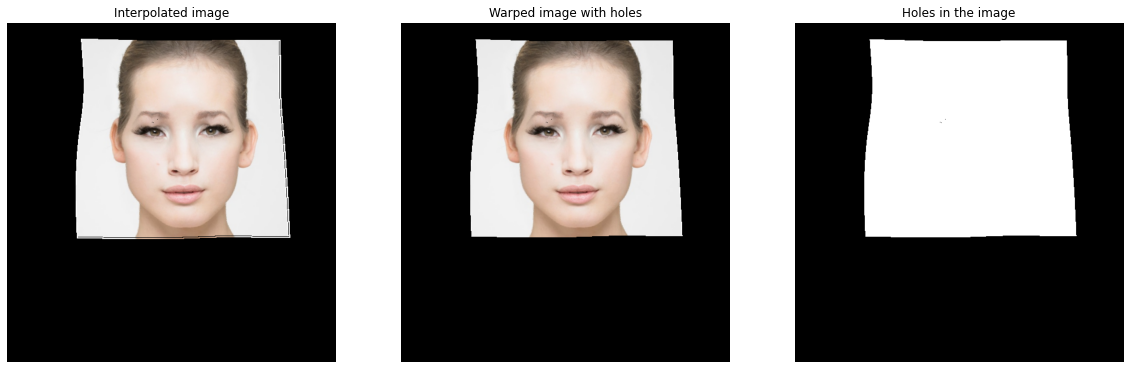

In [20]:
fig = plt.figure(figsize = (20, 60))

fig.add_subplot(1, 3, 1)
plt.imshow(a_disp)
plt.axis('off')
plt.title("Interpolated image")

fig.add_subplot(1, 3, 2)
plt.imshow(b_disp)
plt.axis('off')
plt.title("Warped image with holes")

fig.add_subplot(1, 3, 3)
plt.imshow(c, cmap="gray")
plt.axis('off')
plt.title("Holes in the image")

Text(0.5, 1.0, 'Images superimposed on each other')

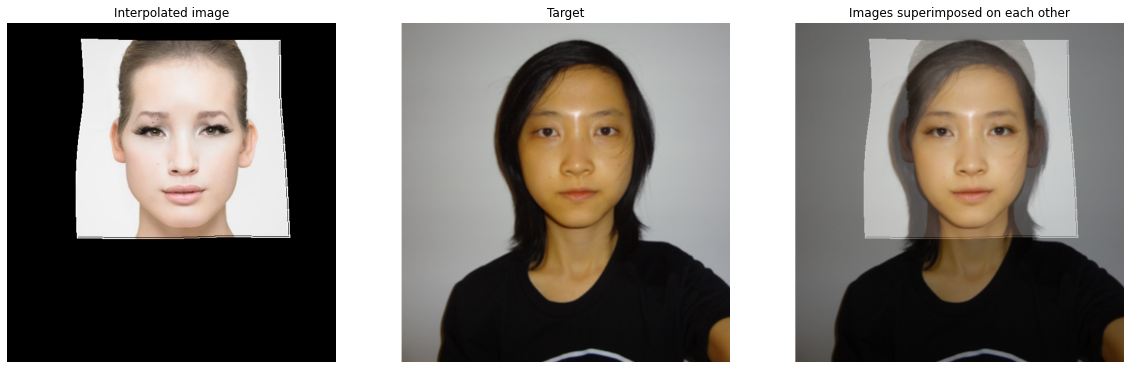

In [21]:
fig = plt.figure(figsize = (20, 60))

fig.add_subplot(1, 3, 1)
plt.imshow(a_disp)
plt.axis('off')
plt.title("Interpolated image")

fig.add_subplot(1, 3, 2)
plt.imshow(target_color)
plt.axis('off')
plt.title("Target")

super_imposed = np.floor(a_disp * 0.3 + target_color * 0.7).astype(dtype=np.uint8)
fig.add_subplot(1, 3, 3)
plt.imshow(super_imposed)
plt.axis('off')
plt.title("Images superimposed on each other")

### saving warped image

In [22]:
cv2.imwrite(os.path.join(GEN_IMAGES_PATH,'interpolated_image.png'), cv2.cvtColor(a_disp, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(GEN_IMAGES_PATH,'superimposed_image.png'), cv2.cvtColor(super_imposed, cv2.COLOR_BGR2RGB))

True